<a href="https://www.kaggle.com/code/esracum/zero-shot-image-classification-using-clip?scriptVersionId=294314076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Zero Shot Image Classification using CLIP

In this notebook, we will learn about **Zero-Shot Image Classification** using a Vision Language Model (VLM) called CLIP.

![Yapay Sinir Ağı Görseli](https://github.com/esracum/computer-vision/blob/main/z_clip.png?raw=true)

**Image Classification** is a class of techniques where the input is an image and the output is a single class label from a collection of pre-defined classes. For example, given an image of a cat, an image classifier would output the label "cat".

**CLIP (Contrastive Language-Image Pre-training)** is a multimodal model developed by OpenAI that learns to associate images with their textual descriptions, enabling tasks like zero-shot classification and image retrieval.

# Imports

In [1]:
# Import necessary libraries
from PIL import Image # Used for image processing
import requests # Used for downloading images from URLs (if needed)
from transformers import CLIPProcessor, CLIPModel # Import CLIP processor and model from Hugging Face Transformers
import torch # Import PyTorch

# Use to display image
from IPython.display import display

2026-01-27 10:07:32.918146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769508453.172325      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769508453.244958      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769508453.840154      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769508453.840199      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769508453.840202      17 computation_placer.cc:177] computation placer alr

# Load Model
We will load a version of CLIP `openai/clip-vit-base-patch32`. It has the following characteristics.

- **Architecture**: Combines Vision Transformer (ViT) with a text transformer.
- **Purpose**: Aligns images and text into a shared embedding space for multimodal tasks.
- **Training Data**: Trained on 400M image-text pairs scraped from the internet.
- **Model size**: Approximately 82M. Easily fits in a consumer grade GPU.
- **Applications**: Image classification, zero-shot learning, image retrieval, and image captioning.


In [2]:
# Load the pre-trained CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

# Load CLIP Preprocessor
The CLIP processor, loaded with the following line:

```python
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
```

has a crucial role in preparing input data (both images and text labels) for the CLIP model.


Internally the CLIPProcessor applies the following set of preprocessing steps to the batch of images and text tokens.

```bash
CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

```

### Here's a breakdown of what the processor does:

### 1. **Image Processing**
- **Resizing**: Adjusts images to a consistent size expected by the model (e.g., 224x224 pixels).
- **Center Cropping**: Crops the central portion of the image, ensuring the primary subject remains the focal point.
- **Data Type Conversion**: Converts images into PyTorch tensors, the format required by CLIP.
- **Normalization**: Scales pixel values to a standard range, allowing the model to process data efficiently and consistently.

### 2. **Text Processing**
- **Tokenization**: Splits text labels into individual tokens (words or sub-words).
- **Padding and Truncation**: Ensures all text sequences are of uniform length by padding shorter sequences with special tokens or truncating longer sequences. Controlled via the `padding=True` argument.
- **Data Type Conversion**: Converts text tokens into PyTorch tensors using special embeddings compatible with the CLIP model.

### 3. **Combining Inputs**
The processor combines the processed image and text tensors into a single dictionary-like object (`inputs`). This object is then passed directly to the CLIP model for prediction.

---

### Why is the CLIP Processor important?

- **Consistency**: It standardizes inputs, ensuring the model receives data in an optimal format for accurate and generalizable predictions.
- **Efficiency**: Preprocessing saves computational resources by performing necessary data transformations once rather than repeatedly during inference.
- **Abstraction**: It simplifies data preparation steps, allowing users to focus on high-level tasks instead of preprocessing complexities.

In [3]:
# Load processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Load Image & Define Classes

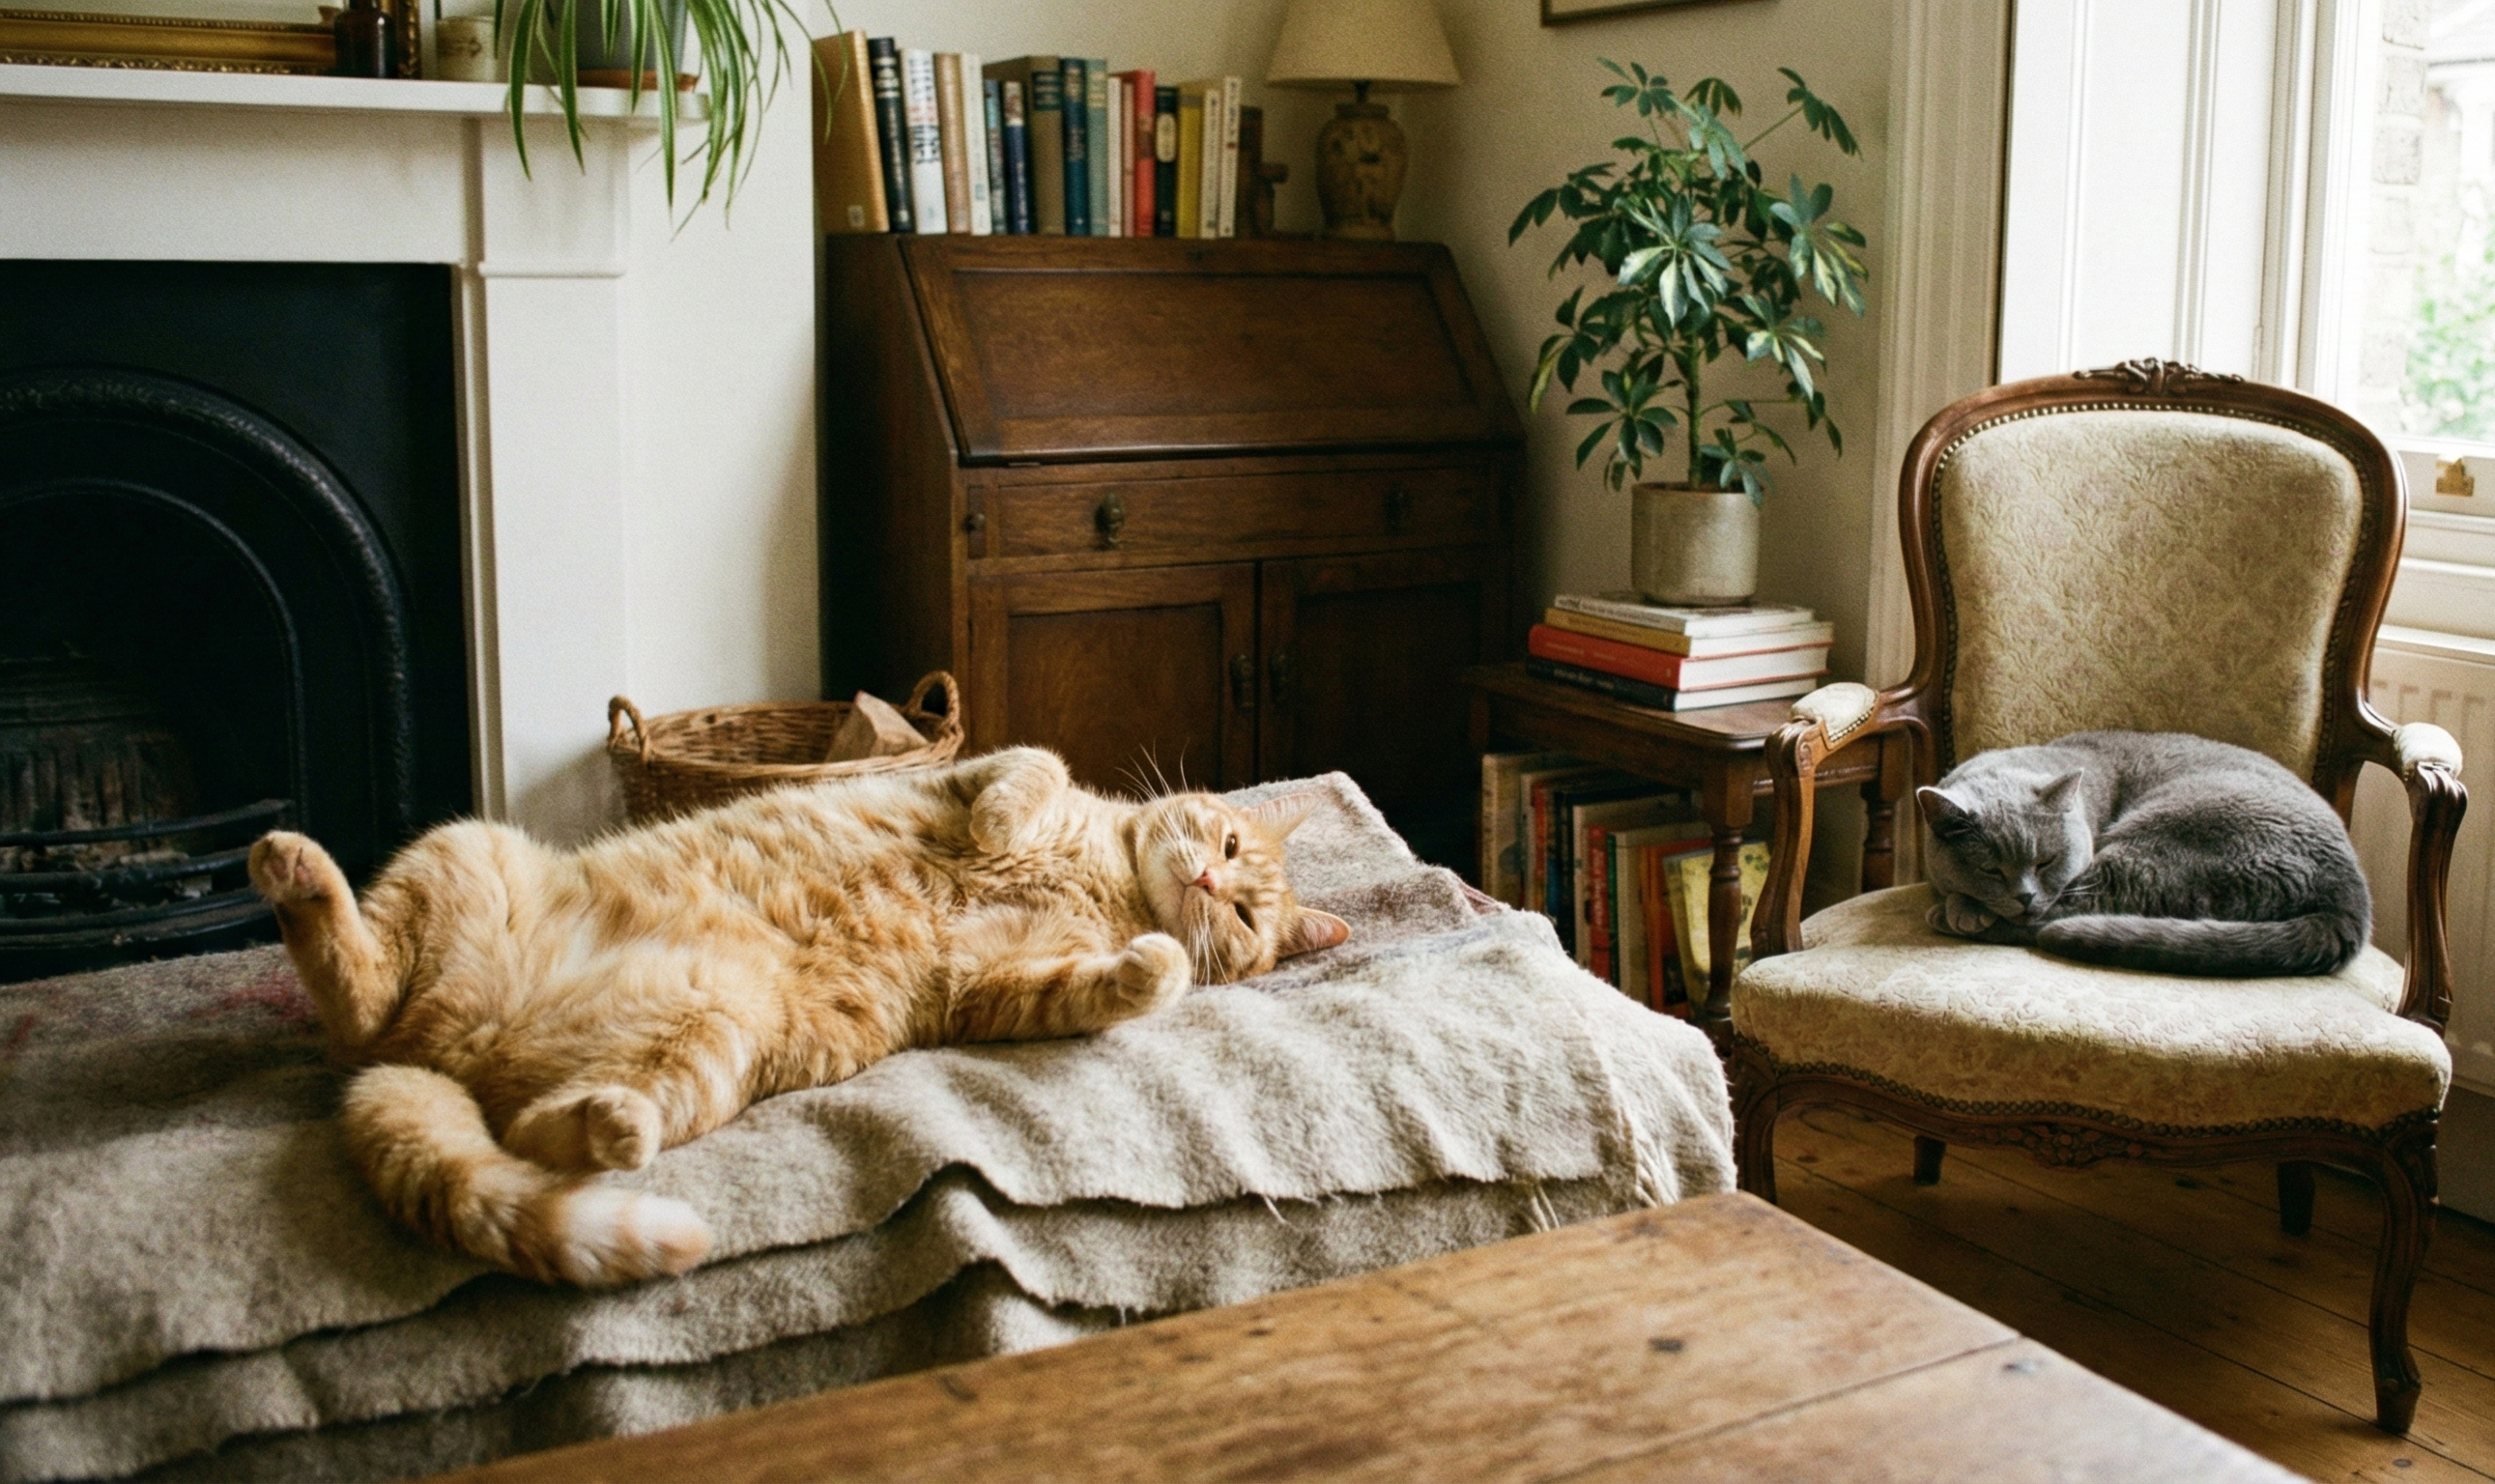

In [4]:
from PIL import Image
import requests
from io import BytesIO

# Görselin ham veri (raw) linki
url = "https://github.com/esracum/computer-vision/blob/main/z_cats.png?raw=true" 

response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Görseli göster
display(image)

# Define ouput classes

In [5]:
# Define the list of target labels/categories
text = ["cat", "dog", "rabbit"]

# Convert raw data to model inputs

In [6]:
# Preprocess the text and image using the CLIP processor
# return_tensors="pt" specifies to return PyTorch tensors
# padding=True ensures inputs are padded to the same length
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

In [7]:
# Unpack the inputs
input_ids = inputs.input_ids  # Tokenized and encoded text input IDs
# Print information about the unpacked inputs
print("Input IDs (shape):", input_ids.shape)
print(input_ids)

Input IDs (shape): torch.Size([3, 3])
tensor([[49406,  2368, 49407],
        [49406,  1929, 49407],
        [49406, 10274, 49407]])


#### inputs.**attention_mask**
This is a binary mask used to indicate which tokens in the input_ids are actual words and which are padding tokens. It helps the model to focus on the relevant parts of the input sequence. Values of 1 indicate valid tokens, and values of 0 indicate padding.

In [8]:
attention_mask = inputs.attention_mask # Mask indicating which tokens are valid (1) vs. padding (0)
print("Attention Mask (shape):", attention_mask.shape)
print(attention_mask)

Attention Mask (shape): torch.Size([3, 3])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])


#### inputs.**pixel_values**

In [9]:
pixel_values = inputs.pixel_values # Processed image pixel values
print("Pixel Values (shape):", pixel_values.shape)
print(pixel_values)

Pixel Values (shape): torch.Size([1, 3, 224, 224])
tensor([[[[-0.3908, -0.5660, -0.5076,  ...,  0.5727,  0.4851,  0.5581],
          [-0.4784, -0.6244, -0.7120,  ...,  0.5727,  0.5289,  0.5581],
          [-0.6098, -0.7266, -1.0331,  ...,  0.5727,  0.5289,  0.5727],
          ...,
          [-0.1864, -0.1572, -0.1864,  ...,  0.9084,  0.9084,  0.9522],
          [-0.3908, -0.3908, -0.3762,  ...,  0.9230,  0.9814,  1.0398],
          [-0.4492, -0.4054, -0.4200,  ...,  1.0544,  1.0836,  1.0982]],

         [[-0.3414, -0.5665, -0.4464,  ...,  0.4991,  0.4390,  0.5141],
          [-0.4614, -0.6265, -0.5965,  ...,  0.4691,  0.4240,  0.4691],
          [-0.5815, -0.7166, -0.8216,  ...,  0.4691,  0.4390,  0.4841],
          ...,
          [-0.6115, -0.6115, -0.6415,  ...,  0.6792,  0.7392,  0.8142],
          [-0.8066, -0.8216, -0.7916,  ...,  0.7392,  0.8442,  0.9193],
          [-0.8666, -0.8366, -0.8216,  ...,  0.9193,  0.9493,  0.9493]],

         [[-0.7408, -0.8830, -0.8119,  ...,  0.1977

# Forward pass to get output

In [10]:
# Ensure no gradients are calculated for faster inference.
with torch.no_grad():
  outputs = model(**inputs) # Pass the inputs to the model

In [11]:
print(outputs.text_embeds.shape)
print(outputs.image_embeds.shape)

logits_per_image = outputs.logits_per_image # Extract the image-text similarity scores
print("Logits Per Image (shape):", logits_per_image.shape) #The higher the score, the more similar the image is to that label.
print(logits_per_image)

# τ   (temperature multiplier)
temperature = model.logit_scale.exp().item()
print(f"Cosine similarity is scaled by: {temperature:.3f}")

torch.Size([3, 512])
torch.Size([1, 512])
Logits Per Image (shape): torch.Size([1, 3])
tensor([[24.7332, 20.7259, 20.5604]])
Cosine similarity is scaled by: 100.000


### Convert scores to probabilities using softmax

The softmax function is used to convert a vector of raw scores (often called logits) into probabilities that sum to 1. It is commonly applied in classification tasks to interpret model outputs. Letus walk through the math step-by-step.

#### Softmax Formula
For a vector of raw scores $z = [z_1, z_2, ..., z_n]$, the softmax function computes the probability $P_i$ for the $i$-th element as:

$$
P_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

Where:
- $z_i$ is the raw score (logit) for the $i$-th class,
- $e^{z_i}$ is the exponential of that score,
- $\sum_{j=1}^{n} e^{z_j}$ is the sum of the exponentials of all scores, acting as a normalization factor,
- $P_i$ is the resulting probability for the $i$-th class.

In [12]:
probs = logits_per_image.softmax(dim=-1) # Apply softmax to get probabilities for each label

# Print output probabilities

In [13]:
# Print the probabilities for each class
for i, label in enumerate(text): # Loop through the labels and their indices
  print(f"Probability of {label}: {probs[0][i].item()}") # Print the probability for each label

# Get the predicted label
predicted_label = text[probs.argmax()] # Get the label with the highest probability
print(f"\nPredicted Label: {predicted_label}") # Print the predicted label

Probability of cat: 0.9674996733665466
Probability of dog: 0.017591798678040504
Probability of rabbit: 0.014908595941960812

Predicted Label: cat
